In [2]:
# Haversine-Formel zur Berechnung der Distanz zwischen zwei geographischen Punkten (in Kilometern)
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0088  # Erdradius in Kilometern
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)
    
    a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    distance = R * c  # Distanz in Kilometern
    return distance

coordinates = geo[['latitude', 'longitude']].to_numpy()
# Berechne alle paarweise Entfernungen in Kilometern (auf Basis der Haversine-Formel)
n_points = len(coordinates)
distances_matrix = np.zeros((n_points, n_points))
for i in range(n_points):
    for j in range(i + 1, n_points):
        lat1, lon1 = coordinates[i]
        lat2, lon2 = coordinates[j]
        distance = haversine(lat1, lon1, lat2, lon2)
        distances_matrix[i, j] = distance
        distances_matrix[j, i] = distance

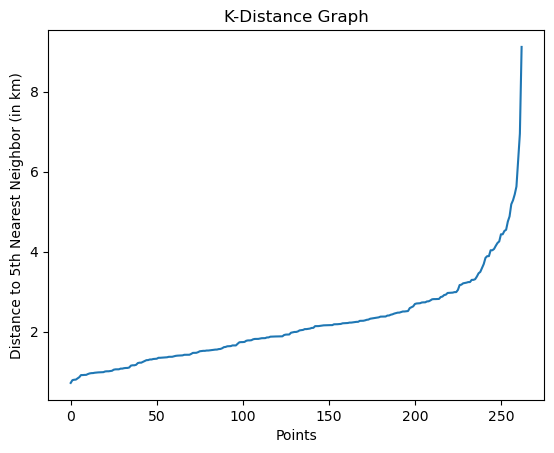

In [3]:
from sklearn.neighbors import NearestNeighbors
#  k-nächsten Nachbarn (z.B. k=6)
neighbors = NearestNeighbors(n_neighbors=5, metric='precomputed') 
neighbors_fit = neighbors.fit(distances_matrix)
# Distanzen zu den k-nächsten Nachbarn (für den 5. Nachbarn, Index 5-1 = 4)
distances, _ = neighbors_fit.kneighbors(distances_matrix)
distances = np.sort(distances[:, 5 - 1])
plt.plot(distances)
plt.title("K-Distance Graph")
plt.xlabel("Points")
plt.ylabel("Distance to 5th Nearest Neighbor (in km)")
plt.show()

In [4]:
if np.isnan(distances_matrix).any():
    print("There are NaN values in the distance matrix!")
else:
    print("No NaN values in the distance matrix.")

No NaN values in the distance matrix.


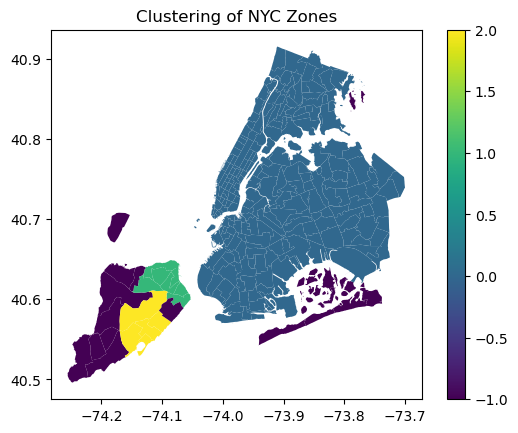

In [5]:
from sklearn.cluster import DBSCAN
db = DBSCAN(eps=3, min_samples=5, metric='precomputed').fit(distances_matrix)
geo['cluster'] = db.labels_
geo.plot(column='cluster', cmap='viridis', legend=True)
plt.title("Clustering of NYC Zones")
plt.show()

**Non sense; DBSCAN may be affected by different geoshapes area sizes** 

In [7]:
doFre = trips.groupby(['DOLocationID']).size().reset_index(name='DOfrequency')
geo_doFre = geo.merge(doFre, left_on='LocationID', right_on='DOLocationID', how='inner').fillna(0)

In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
geo_doFre['scaled_frequency'] = scaler.fit_transform(geo_doFre[['DOfrequency']])

In [12]:
geo_doFre['lat_rad'] = np.radians(geo_doFre['latitude'])
geo_doFre['long_rad'] = np.radians(geo_doFre['longitude'])
features = geo_doFre[['lat_rad', 'long_rad']].values
weights = geo_doFre['scaled_frequency'].values
print(len(features))
print(len(sample_weights))

261
261


In [13]:
earth_radius = 6371.0088
db = DBSCAN(eps=3/earth_radius, min_samples=5, metric='haversine')
labels = db.fit_predict(features, sample_weight=weights)
geo['cluster'] = labels
geo.plot(column='cluster', cmap='viridis', legend=True)
plt.title("Clustering of NYC Zones")
plt.show()

ValueError: Length of values (261) does not match length of index (263)

In [32]:
dbscan = DBSCAN(eps=eps, min_samples=minPts, metric='haversine')
labels = dbscan.fit_predict(features, sample_weight=sample_weights)
geo['cluster'] = labels

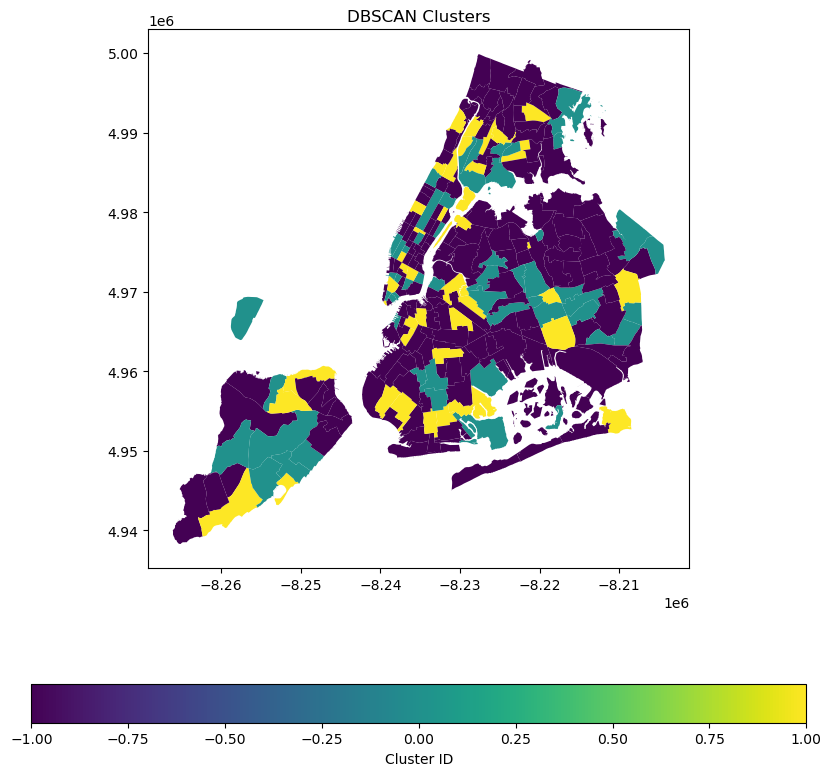

In [214]:
fig, ax = plt.subplots(figsize=(10, 10))
merged.plot(column='cluster', ax=ax, legend=True,
               legend_kwds={'label': "Cluster ID", 'orientation': "horizontal"})
plt.title("DBSCAN Clusters")
plt.show()

In [33]:
merged['cluster'].nunique()

1

In [108]:
merged['frequency'].describe()

count       259.00000
mean      66619.38610
std       58348.09606
min          43.00000
25%       25197.50000
50%       49842.00000
75%       95217.50000
max      407262.00000
Name: frequency, dtype: float64

In [216]:
from sklearn.metrics import silhouette_score
score = silhouette_score(features, labels)
print(f'Silhouette Score: {score}')
from sklearn.metrics import davies_bouldin_score
score = davies_bouldin_score(features, labels)
print(f'Davies-Bouldin Index: {score}')
from sklearn.metrics import calinski_harabasz_score
score = calinski_harabasz_score(features, labels)
print(f'Calinski-Harabasz Index: {score}')
noise_ratio = sum(labels == -1) / len(labels)
print(f'Noise Proportion: {noise_ratio:.2%}')
import numpy as np
unique, counts = np.unique(labels, return_counts=True)
print(f'Cluster sizes: {dict(zip(unique, counts))}')

Silhouette Score: -0.023083962254727464
Davies-Bouldin Index: 12.92325216380634
Calinski-Harabasz Index: 0.8012955462826722
Noise Proportion: 62.55%
Cluster sizes: {-1: 162, 0: 54, 1: 43}


In [29]:
k_means_featues = merged[['latitude', 'longitude', 'scaled_frequency']]

In [51]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=7, random_state=42)
merged['k_means_cluster'] = kmeans.fit_predict(k_means_featues)

C:\Users\r-cet\anaconda3\envs\DSML_env\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\r-cet\anaconda3\envs\DSML_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


In [52]:
merged['k_means_cluster'].nunique()

7

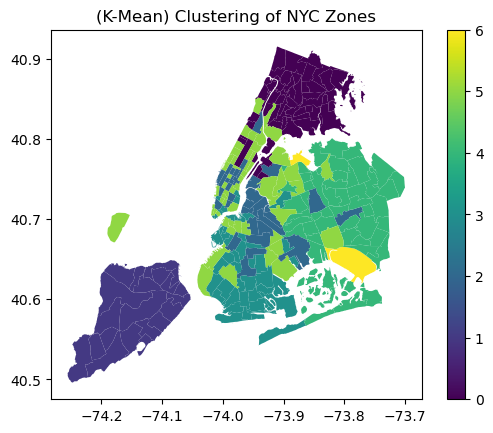

In [53]:
merged.plot(column='k_means_cluster', cmap='viridis', legend=True)
plt.title("(K-Mean) Clustering of NYC Zones")
plt.show()